In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import IPython.display as display
from PIL import Image

from sklearn.model_selection import train_test_split


In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

2.5.0


In [41]:
colon_main = pd.read_csv("./Image_classification_data/data_labels_mainData.csv")

In [4]:
colon_main.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [5]:
colon_main.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

In [6]:
colon_main.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [7]:
train_data, test_data = train_test_split(colon_main, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, \nVal Data: {}, \nTest Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, 
Val Data: 1979, 
Test Data: 1980


In [8]:
colon_main.isCancerous.value_counts()

0    5817
1    4079
Name: isCancerous, dtype: int64

In [ ]:
colon_main.isCancerous.hist()
plt.show()

In [ ]:
r_inx = np.random.choice(100, 4)
rand_data = colon_main.loc[r_inx,'ImageName']

plt.figure(figsize=(16,4))

for i, path in enumerate(rand_data):
    image_path = "./Image_classification_data/patch_images/" + path
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

In [ ]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [ ]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150)

In [22]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [ ]:
model.save("detect_cancer")

In [ ]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.evaluate(test_generator)

In [ ]:
label_names = {'cancer' : 0, 'noCancer' : 1}

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [28]:
colon_main.cellType.value_counts()

2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64

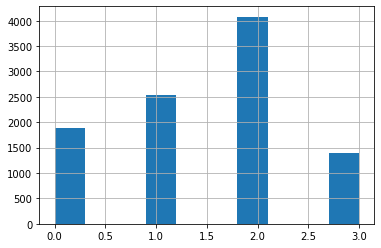

In [29]:
colon_main.cellType.hist()
plt.show()

In [30]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [31]:
cell_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [32]:
cell_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


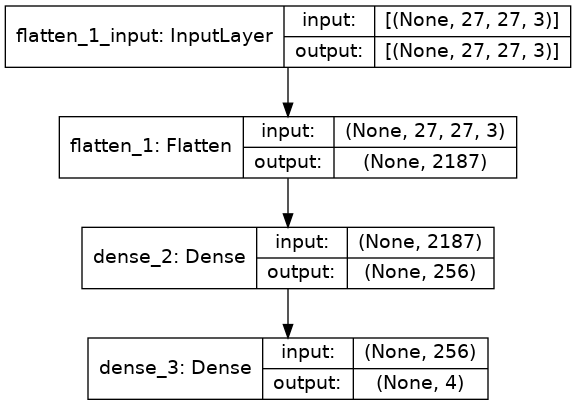

In [33]:
tf.keras.utils.plot_model(cell_model, show_shapes=True)

In [34]:
cell_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [35]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

cell_train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
cell_val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

cell_train_generator = cell_train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator = cell_val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [36]:
cell_history = cell_model.fit_generator(cell_train_generator, validation_data = cell_validation_generator, epochs=150)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
220/220 [==============================] - 4s 16ms/step - loss: 1.2527 - categorical_accuracy: 0.4635 - val_loss: 1.1939 - val_categorical_accuracy: 0.4805
Epoch 2/150
220/220 [==============================] - 3s 15ms/step - loss: 1.1614 - categorical_accuracy: 0.5215 - val_loss: 1.1246 - val_categorical_accuracy: 0.5629
Epoch 3/150
220/220 [==============================] - 3s 15ms/step - loss: 1.0886 - categorical_accuracy: 0.5604 - val_loss: 1.0549 - val_categorical_accuracy: 0.5760
Epoch 4/150
220/220 [==============================] - 3s 15ms/step - loss: 1.0334 - categorical_accuracy: 0.5868 - val_loss: 1.0383 - val_categorical_accuracy: 0.5503
Epoch 5/150
220/220 [==============================] - 3s 15ms/step - loss: 0.9836 - categorical_accuracy: 0.6185 - val_loss: 0.9743 - val_categorical_accuracy: 0.6726
Epoch 6/150
220/220 [==============================] - 4s 16ms/step - loss: 0.9483 - categorical_accuracy: 0.6363 - val_loss: 0.9245 - val_categorical_accuracy:

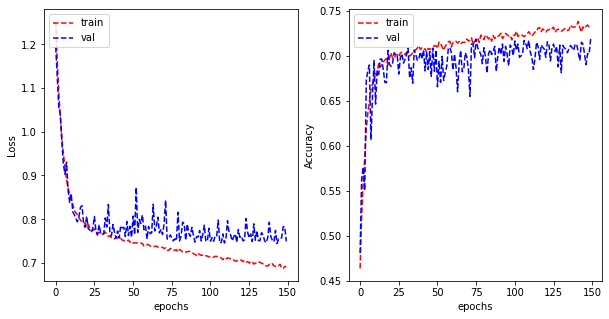

In [37]:
plot_learning_curve(cell_history.history['loss'], cell_history.history['val_loss'], 
                    cell_history.history['categorical_accuracy'], cell_history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [38]:
test_data['cellType'] = test_data['cellType'].astype('str')

cell_test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

cell_test_generator = cell_test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
cell_model.evaluate(cell_test_generator)

In [ ]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

In [ ]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_test_generator:
        batches = batches + 1
        y_hat = cell_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [ ]:
cell_model.save("predict_celltype")

In [42]:
colon_main_copy = colon_main.copy()

In [43]:
colon_main_copy.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [44]:
colon_main_copy.drop(['cellTypeName'], axis=1, inplace=True)

In [45]:
cell_train_data, cell_val_data = train_test_split(colon_main_copy, test_size=0.2, random_state=42)

print("Train data : {}, \nVal Data: {}".format(cell_train_data.shape[0], cell_val_data.shape[0]))

Train data : 7916, 
Val Data: 1980


In [46]:
cell_train_data.head()

,InstanceID,patientID,ImageName,cellType,isCancerous
3111,8379,18,8379.png,2,1
742,9043,7,9043.png,0,0
6087,20555,37,20555.png,0,0
5669,11310,32,11310.png,3,0
4254,20081,23,20081.png,0,0


In [47]:
INPUT_DIM = (27, 27, 3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [48]:
cell_model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [49]:
cell_model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2187)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               560128    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


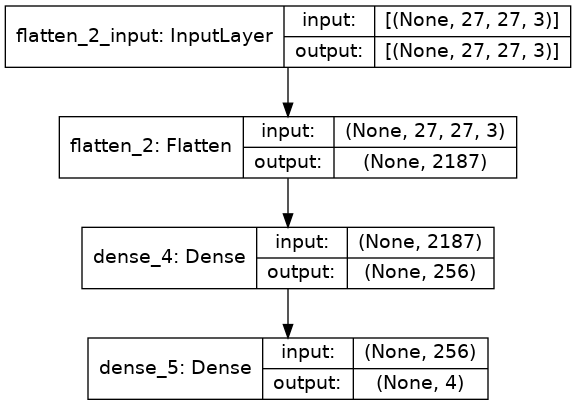

In [50]:
tf.keras.utils.plot_model(cell_model1, show_shapes=True)

In [51]:
cell_model1.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

cell_train_data['cellType'] = cell_train_data['cellType'].astype('str')
cell_val_data['cellType'] = cell_val_data['cellType'].astype('str')

cell_train_datagen1 = ImageDataGenerator(rescale=1./255, data_format='channels_last')
cell_val_datagen1 = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

cell_train_generator1 = cell_train_datagen1.flow_from_dataframe(
        dataframe=cell_train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

cell_validation_generator1 = cell_val_datagen1.flow_from_dataframe(
        dataframe=cell_val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 7916 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
cell_history1 = cell_model1.fit_generator(cell_train_generator1, validation_data = cell_validation_generator1, epochs=150)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
294/294 [==============================] - 5s 15ms/step - loss: 1.2325 - categorical_accuracy: 0.4660 - val_loss: 1.1995 - val_categorical_accuracy: 0.5500
Epoch 2/150
294/294 [==============================] - 4s 14ms/step - loss: 1.1232 - categorical_accuracy: 0.5428 - val_loss: 1.1024 - val_categorical_accuracy: 0.5581
Epoch 3/150
294/294 [==============================] - 4s 15ms/step - loss: 1.0439 - categorical_accuracy: 0.5875 - val_loss: 1.0188 - val_categorical_accuracy: 0.5798
Epoch 4/150
294/294 [==============================] - 4s 14ms/step - loss: 0.9793 - categorical_accuracy: 0.6194 - val_loss: 0.9788 - val_categorical_accuracy: 0.6697
Epoch 5/150
294/294 [==============================] - 4s 14ms/step - loss: 0.9297 - categorical_accuracy: 0.6474 - val_loss: 0.9411 - val_categorical_accuracy: 0.6682
Epoch 6/150
294/294 [==============================] - 4s 14ms/step - loss: 0.8918 - categorical_accuracy: 0.6674 - val_loss: 0.8869 - val_categorical_accuracy:

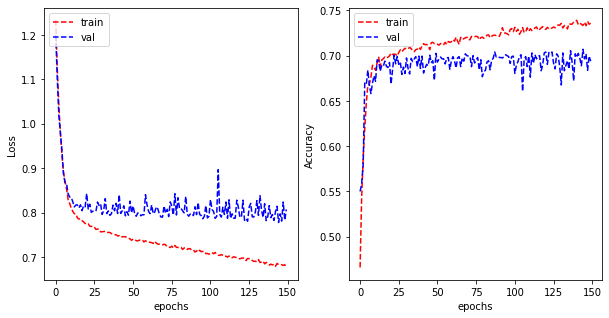

In [54]:
plot_learning_curve(cell_history1.history['loss'], cell_history1.history['val_loss'], 
                    cell_history1.history['categorical_accuracy'], cell_history1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [55]:
cell_model1.save("predict_celltype_extra")

INFO:tensorflow:Assets written to: predict_celltype_extra/assets


In [56]:
colon_extra = pd.read_csv("./Image_classification_data/data_labels_extraData.csv")

In [57]:
colon_extra.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [71]:
from sklearn.datasets import make_blobs

X, colon_extra['cellType'], = make_blobs(n_samples=10384, centers=4, n_features=1, random_state=0)

In [72]:
colon_extra.head()

,InstanceID,patientID,ImageName,isCancerous,cellType
0,12681,61,12681.png,0,0
1,12682,61,12682.png,0,1
2,12683,61,12683.png,0,2
3,12684,61,12684.png,0,3
4,12685,61,12685.png,0,3


In [73]:
colon_extra['cellType'] = colon_extra['cellType'].astype('str')

cell_predict_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

cell_predict_generator = cell_predict_datagen.flow_from_dataframe(
        dataframe=colon_extra,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 10384 validated image filenames belonging to 4 classes.


In [74]:
cell_model1.evaluate(cell_predict_generator)

10384/10384 [==============================] - 17s 2ms/step - loss: 3.1593 - categorical_accuracy: 0.2486


[3.159327268600464, 0.24855546653270721]

In [75]:
label_names = {'fibroblast': 0, 'inflammatory':1, 'epithelial': 2, 'others':3}

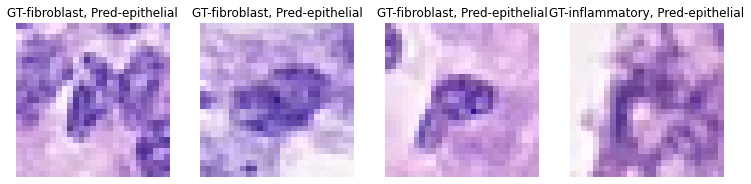

In [81]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in cell_predict_generator:
        batches = batches + 1
        y_hat = cell_model1.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:you syou
            break
        
        plt.axis('off')